## ART BlackBox Classifier - Creating adversarial samples for remote classifiers

This demo consists of two parts. The first part deploys a trained model using IBM Watson Machine Learning service to create an API. The second connects to this endpoint and attacks the deployed model with the HopSkipJump attack using only the model predictions.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
from IPython.display import clear_output
from matplotlib import pyplot as plt

from art import config
from art.estimators.classification import BlackBoxClassifier
from art.attacks.evasion import HopSkipJump
from art.utils import to_categorical
from art.utils import load_dataset, get_file, compute_accuracy

### Deploy model and connect to API

To deploy a model and connect to the endpoint for model predictions, please follow the demo:
[Use TensorFlow to predict handwritten digits](https://dataplatform.cloud.ibm.com/analytics/notebooks/v2/3bd3efb8-833d-460f-b07b-fee51dd0f1af/view?access_token=6bd0ff8d807861d09e0dab0cad28ce9685711078f612fcd92bb8cf8535d089c1)

In [2]:
# generate wml client object following the tutorial above (part 1)
client = 'TODO'

# generate api endpoint following the tutorial above (part 6)
scoring_url = 'TODO'

### Make predictions

We show an example of a predict function below that connects to a wml endpoint and returns the predictions of the deployed model. A different function could be written for another remote classifier that outputs predictions.

In [3]:
# Read MNIST dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str('mnist'))

In [4]:
# Sample predict function that reformats inputs, connects to wml scoring endpoint and 
# returns one-hot encoded predictions
def predict(x):
    x = np.array(x)
    scoring_data = {'values': (np.reshape(x, (x.shape[0],784))).tolist()}
    predictions = client.deployments.score(scoring_url, scoring_data)
    return to_categorical(predictions['values'], nb_classes=10)
    
# Create blackbox object
classifier = BlackBoxClassifier(predict, x_train[0].shape, 10, clip_values=(0, 255))

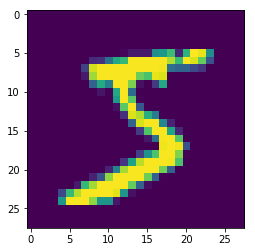

Prediction from API is: 5


In [5]:
# Select target image and show prediction
target_image = x_train[0]
plt.imshow(np.reshape(target_image.astype(np.float32), (28, 28)))
plt.show(block=False)
print('Prediction from API is: ' + str(np.argmax(classifier.predict(x_train[:1]), axis=1)[0]))

### Generate black box HopSkipJump attack

Adversarial image at step 0. L2 error 7.9944905692156425 and class label 3.


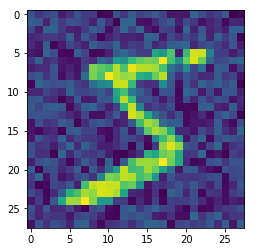

Adversarial image at step 10. L2 error 1.4959683890579352 and class label 3.


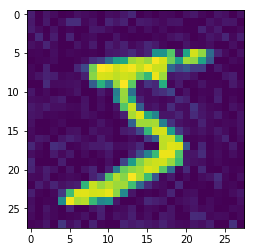

Adversarial image at step 20. L2 error 1.0073771113688348 and class label 3.


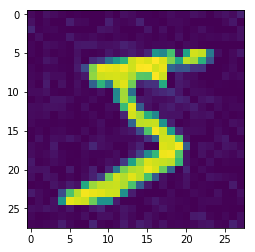

In [6]:
# Generate HopSkipJump attack against black box classifier
attack = HopSkipJump(classifier=classifier, targeted=False, max_iter=0, max_eval=1000, init_eval=10)
iter_step = 10
x_adv = None
for i in range(3):
    x_adv = attack.generate(x=np.array([target_image]), x_adv_init=x_adv)
    
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target_image, [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(np.reshape(x_adv[0].astype(np.float32), (28, 28)))
    plt.show(block=False)
    
    attack.max_iter = iter_step